In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datetime import datetime

## Configuration du device

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de: {device}")

# Version de PyTorch
print(f"Version de PyTorch: {torch.__version__}")

# Vérification de la disponibilité du GPU et ses caractéristiques si disponible
if torch.cuda.is_available():
    print(f"Nom du GPU: {torch.cuda.get_device_name(0)}")
    print(f"Mémoire GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Utilisation de: cpu
Version de PyTorch: 2.7.0+cu126


### Check up

In [89]:
df = pd.read_csv('../data/CustomersFinal.csv')

In [90]:
print(df.dtypes)

customerID                                object
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PaperlessBilling                           int64
MonthlyCharges                           float64
Churn                                      int64
SeniorCitizen_Yes                          int64
InternetService_Fiber optic                int64
InternetService_No                         int64
OnlineSecurity_No internet service         int64
OnlineSecurity_Yes                         int64
TechSupport_Yes                            int64
Contract_One year                          int64
Contract_Two year                          int64
PaymentMethod_Credit card (automatic)      int64
PaymentMethod_Electronic check             int64
dtype: object


In [91]:
print(df.isnull().sum())

customerID                               0
Partner                                  0
Dependents                               0
tenure                                   0
PaperlessBilling                         0
MonthlyCharges                           0
Churn                                    0
SeniorCitizen_Yes                        0
InternetService_Fiber optic              0
InternetService_No                       0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
TechSupport_Yes                          0
Contract_One year                        0
Contract_Two year                        0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
dtype: int64


In [92]:
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

In [93]:
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (7043, 15), y shape: (7043,)


### Split

In [94]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# ÉTAPE MANQUANTE: Deuxième division pour séparer train et validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val
    # 0.1765 équivaut à 15% du dataset original (0.15 / 0.85)
)


In [95]:
print(f"Taille du jeu d'entraînement: {X_train.shape[0]} exemples")
print(f"Taille du jeu de validation: {X_val.shape[0]} exemples")
print(f"Taille du jeu de test: {X_test.shape[0]} exemples")

# Vérification que la stratification a bien fonctionné
print(f"\nDistribution de Churn dans l'ensemble complet: {y.mean():.4f}")
print(f"Distribution de Churn dans l'ensemble d'entraînement: {y_train.mean():.4f}")
print(f"Distribution de Churn dans l'ensemble de validation: {y_val.mean():.4f}")
print(f"Distribution de Churn dans l'ensemble de test: {y_test.mean():.4f}")

Taille du jeu d'entraînement: 4929 exemples
Taille du jeu de validation: 1057 exemples
Taille du jeu de test: 1057 exemples

Distribution de Churn dans l'ensemble complet: 0.2654
Distribution de Churn dans l'ensemble d'entraînement: 0.2654
Distribution de Churn dans l'ensemble de validation: 0.2658
Distribution de Churn dans l'ensemble de test: 0.2649


### Normalisation des features numériques (StandardScaler)
 

In [96]:
numeric_cols = ['tenure', 'MonthlyCharges']
if 'TotalCharges' in X.columns:
    numeric_cols.append('TotalCharges')

# Vérification des colonnes numériques
print(f"Colonnes numériques à normaliser: {numeric_cols}")

# Création et application du StandardScaler
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Aperçu des données après normalisation
print("\nAperçu des données après normalisation:")
print(X_train[numeric_cols].describe())

# Sauvegarde du scaler pour une utilisation future
import pickle
os.makedirs('model', exist_ok=True)
with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\nScaler sauvegardé pour utilisation future.")

Colonnes numériques à normaliser: ['tenure', 'MonthlyCharges']

Aperçu des données après normalisation:
             tenure  MonthlyCharges
count  4.929000e+03    4.929000e+03
mean  -7.928556e-18   -2.027188e-16
std    1.000101e+00    1.000101e+00
min   -1.313275e+00   -1.530791e+00
25%   -9.490814e-01   -9.822720e-01
50%   -1.397630e-01    1.874613e-01
75%    9.528168e-01    8.367624e-01
max    1.600271e+00    1.785106e+00

Scaler sauvegardé pour utilisation future.


### Création du dataset Pytorch

In [97]:
class ChurnDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Création des datasets
train_dataset = ChurnDataset(X_train, y_train)
val_dataset = ChurnDataset(X_val, y_val)
test_dataset = ChurnDataset(X_test, y_test)

# Vérification des dimensions
print(f"Dimensions du dataset d'entraînement: {train_dataset.features.shape}")
print(f"Dimensions du dataset de validation: {val_dataset.features.shape}")
print(f"Dimensions du dataset de test: {test_dataset.features.shape}")


Dimensions du dataset d'entraînement: torch.Size([4929, 15])
Dimensions du dataset de validation: torch.Size([1057, 15])
Dimensions du dataset de test: torch.Size([1057, 15])


### Création de lots d'entraînement 

In [98]:
batch_size = 32

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Vérification des DataLoaders
print(f"Nombre de batches dans le train_loader: {len(train_loader)}")
print(f"Nombre de batches dans le val_loader: {len(val_loader)}")
print(f"Nombre de batches dans le test_loader: {len(test_loader)}")

# Visualisation d'un batch
for batch_features, batch_targets in train_loader:
    print(f"\nDimensions d'un batch de features: {batch_features.shape}")
    print(f"Dimensions d'un batch de targets: {batch_targets.shape}")
    break 

Nombre de batches dans le train_loader: 155
Nombre de batches dans le val_loader: 34
Nombre de batches dans le test_loader: 34

Dimensions d'un batch de features: torch.Size([32, 15])
Dimensions d'un batch de targets: torch.Size([32, 1])


### Définition du modèle

In [99]:

class ChurnMLP(nn.Module):
    def __init__(self, input_size):
        super(ChurnMLP, self).__init__()
        
        # Architecture avec trois couches cachées
        self.fc1 = nn.Linear(input_size, 32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(16, 8)
        self.relu3 = nn.ReLU()
        
        # Couche de sortie (1 neurone avec activation sigmoid pour classification binaire)
        self.fc4 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.relu3(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Création du modèle
input_size = X_train.shape[1]
model = ChurnMLP(input_size).to(device)

# Affichage du résumé du modèle
print(model)
print(f"\nNombre de paramètres: {sum(p.numel() for p in model.parameters())}")

ChurnMLP(
  (fc1): Linear(in_features=15, out_features=32, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=16, out_features=8, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Nombre de paramètres: 1185


### Configuration de l'entrainement

In [100]:
# Calcul des poids pour gérer le déséquilibre des classes
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum()]).to(device)
print(f"Poids positif pour la classe minoritaire (Churn=1): {pos_weight.item():.4f}")

# Fonction de perte avec pondération des classes
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimiseur Adam avec un learning rate de 0.001
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Scheduler pour réduire le learning rate si la performance stagne
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Nombres d'époques
num_epochs = 50


Poids positif pour la classe minoritaire (Churn=1): 2.7683


### Fonctions des métriques d'évaluation du modèle

In [101]:
def calculate_accuracy(y_pred, y_true):
    """Calcule l'exactitude des prédictions"""
    predicted = y_pred.ge(.5).view(-1)
    return (predicted == y_true).sum().float() / len(y_true)

def calculate_metrics(y_pred, y_true):
    """Calcule plusieurs métriques pour l'évaluation du modèle"""
    y_pred_tag = y_pred.ge(.5).view(-1).cpu().numpy()
    y_true = y_true.cpu().numpy()
    
    # Matrice de confusion pour calculer les métriques
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_tag, labels=[0, 1]).ravel()
    
    # Calcul des métriques
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1
    }

# Permet d'entrainer le modèle pendant une époque
def train_epoch(model, data_loader, criterion, optimizer, device):
    """Entraîne le modèle pendant une époque"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass et optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Suivi des statistiques
        running_loss += loss.item() * inputs.size(0)
        pred = outputs.ge(.5).view(-1)
        correct += (pred == targets.view(-1)).sum().item()
        total += targets.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Permet d'évaluer le modèle suur l'ensemble de validation
def validate_epoch(model, data_loader, criterion, device):
    """Valide le modèle sur l'ensemble de validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Suivi des statistiques
            running_loss += loss.item() * inputs.size(0)
            pred = outputs.ge(.5).view(-1)
            correct += (pred == targets.view(-1)).sum().item()
            total += targets.size(0)
            
            # Stockage pour calcul de métriques détaillées
            all_preds.append(outputs.cpu())
            all_targets.append(targets.view(-1).cpu())
    
    # Concaténation des prédictions et cibles
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # Calcul des métriques
    metrics = calculate_metrics(all_preds, all_targets)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, metrics

### Entraînement et sauvegarde du meilleur modèle

In [102]:
# Early stopping pour éviter le surapprentissage
early_stopping_patience = 10
best_val_loss = float('inf')
early_stopping_counter = 0
best_epoch = 0

# Pour suivre les métriques pendant l'entraînement
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_recall': []
}

print("Début de l'entraînement...")
for epoch in range(num_epochs):
    # Entraînement pour une époque
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc, val_metrics = validate_epoch(model, val_loader, criterion, device)
    
    # Mise à jour du scheduler
    scheduler.step(val_loss)
    
    # Enregistrement des métriques
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_metrics['f1'])
    history['val_recall'].append(val_metrics['recall'])
    
    # Affichage des métriques
    print(f"Époque {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
          f"Val F1: {val_metrics['f1']:.4f}, Val Recall: {val_metrics['recall']:.4f}")
    
    # Sauvegarde du meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        early_stopping_counter = 0
        
        # Sauvegarde du modèle
        torch.save(model.state_dict(), '../checkpoints/best_model.pth')
        print(f"Meilleur modèle sauvegardé à l'époque {epoch+1}")
    else:
        early_stopping_counter += 1
    
    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping déclenché après {epoch+1} époques")
        break

print(f"Entraînement terminé! Meilleur modèle à l'époque {best_epoch+1}")

Début de l'entraînement...


Époque 1/50 - Train Loss: 1.0194, Train Acc: 0.6521, Val Loss: 0.9569, Val Acc: 0.7843, Val F1: 0.5065, Val Recall: 0.4164
Meilleur modèle sauvegardé à l'époque 1
Époque 2/50 - Train Loss: 0.9450, Train Acc: 0.7949, Val Loss: 0.9463, Val Acc: 0.7739, Val F1: 0.6023, Val Recall: 0.6441
Meilleur modèle sauvegardé à l'époque 2
Époque 3/50 - Train Loss: 0.9398, Train Acc: 0.7896, Val Loss: 0.9421, Val Acc: 0.7862, Val F1: 0.6007, Val Recall: 0.6050
Meilleur modèle sauvegardé à l'époque 3
Époque 4/50 - Train Loss: 0.9356, Train Acc: 0.7906, Val Loss: 0.9385, Val Acc: 0.7881, Val F1: 0.6098, Val Recall: 0.6228
Meilleur modèle sauvegardé à l'époque 4
Époque 5/50 - Train Loss: 0.9219, Train Acc: 0.7884, Val Loss: 0.9167, Val Acc: 0.7777, Val F1: 0.6216, Val Recall: 0.6868
Meilleur modèle sauvegardé à l'époque 5
Époque 6/50 - Train Loss: 0.9067, Train Acc: 0.7864, Val Loss: 0.9132, Val Acc: 0.7862, Val F1: 0.6130, Val Recall: 0.6370
Meilleur modèle sauvegardé à l'époque 6
Époque 7/50 - Train Lo

### Chargement du meilleur modèle et évaluation finale

In [103]:
# Chargement du meilleur modèle
best_model = ChurnMLP(input_size).to(device)
best_model.load_state_dict(torch.load('../checkpoints/best_model.pth'))
best_model.eval()

# Évaluation sur l'ensemble de test
test_loss, test_acc, test_metrics = validate_epoch(best_model, test_loader, criterion, device)

print(f"Résultats sur l'ensemble de test:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-score: {test_metrics['f1']:.4f}")

# Prédictions détaillées pour la courbe ROC et d'autres analyses
all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_model(inputs)
        
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

# Concaténation des résultats
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Calcul de l'AUC-ROC
auc_roc = roc_auc_score(all_targets, all_preds)
print(f"AUC-ROC: {auc_roc:.4f}")

Résultats sur l'ensemble de test:
Accuracy: 0.7767
Precision: 0.5647
Recall: 0.6857
F1-score: 0.6194
AUC-ROC: 0.8366


Résultats sur l'ensemble de test:
Accuracy: 0.7758
Precision: 0.5620
Recall: 0.6964
F1-score: 0.6220
AUC-ROC: 0.8382

### Visualisation de la matrice de confusion et courbe ROC

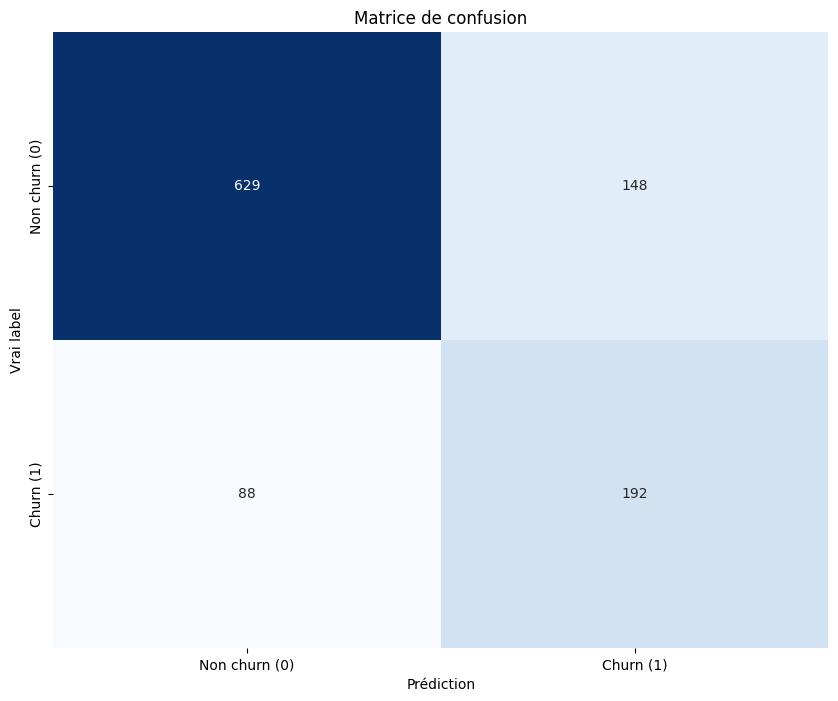

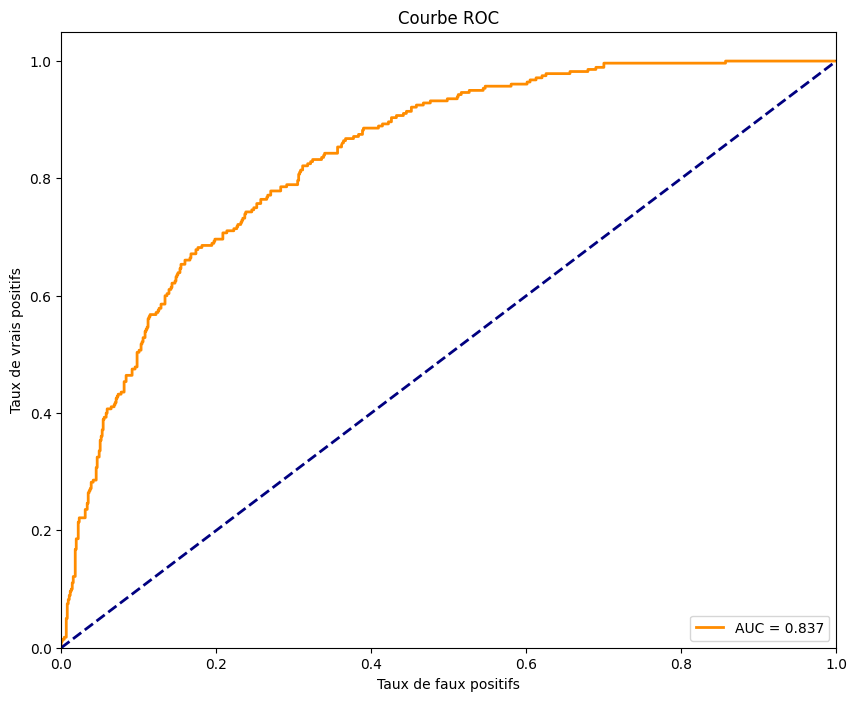

In [104]:
# Calcul de la matrice de confusion
y_pred = (all_preds >= 0.5).astype(int)
cm = confusion_matrix(all_targets, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.xticks([0.5, 1.5], ['Non churn (0)', 'Churn (1)'])
plt.yticks([0.5, 1.5], ['Non churn (0)', 'Churn (1)'])
plt.show()

# Calcul et affichage de la courbe ROC
fpr, tpr, _ = roc_curve(all_targets, all_preds)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_roc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### Features importance

Calcul de l'importance des features (cela peut prendre un moment)...

Importance des features (par permutation):
tenure: 0.046925
TechSupport_Yes: 0.002649
OnlineSecurity_Yes: 0.002649
SeniorCitizen_Yes: 0.002081
Contract_One year: 0.000946
Partner: 0.000568
Dependents: 0.000568
InternetService_Fiber optic: 0.000568
MonthlyCharges: 0.000000
PaymentMethod_Credit card (automatic): -0.001892
InternetService_No: -0.003595
PaperlessBilling: -0.004163
Contract_Two year: -0.006055
PaymentMethod_Electronic check: -0.006055
OnlineSecurity_No internet service: -0.006623


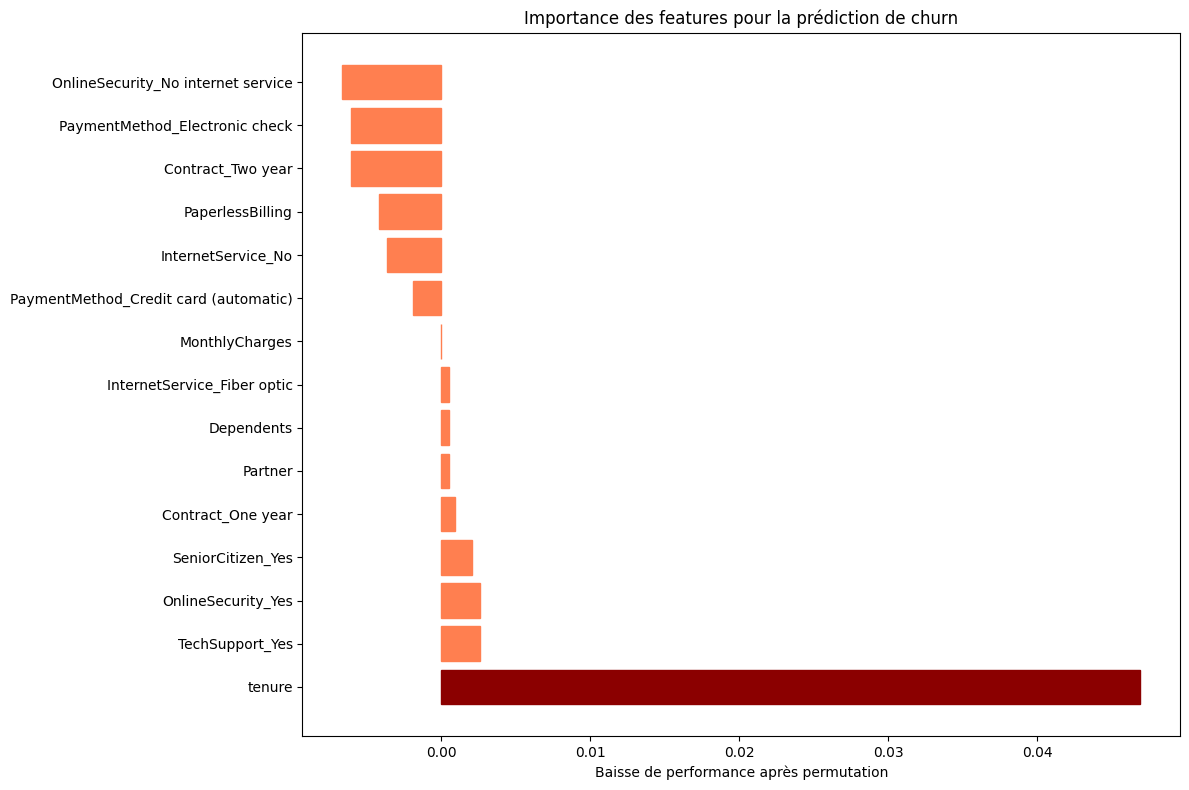

In [105]:
# Cellule 16: Analyse de l'importance des features
# ---------------------------------------------
# Estimation de l'importance des features par permutation

def feature_importance_permutation(model, X_data, y_data, device, n_repeats=10):
    """
    Calcule l'importance des features par permutation.
    L'idée est de permuter aléatoirement une colonne et de mesurer la baisse de performance.
    Plus la baisse est importante, plus la feature est importante.
    """
    # Conversion en tenseurs et déplacement vers le device approprié
    X_tensor = torch.tensor(X_data.values, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_data.values, dtype=torch.float32).reshape(-1, 1).to(device)
    
    # Calcul de la performance de base
    model.eval()
    with torch.no_grad():
        base_preds = model(X_tensor)
        base_score = calculate_accuracy(base_preds, y_tensor.view(-1))
    
    # Calcul de l'importance pour chaque feature
    importances = []
    for col_idx, column in enumerate(X_data.columns):
        # Répéter plusieurs fois pour réduire la variance
        col_importance = []
        for _ in range(n_repeats):
            # Copie du tenseur original
            X_permuted = X_tensor.clone()
            
            # Permutation aléatoire de la colonne
            perm_idx = torch.randperm(len(X_permuted))
            X_permuted[:, col_idx] = X_permuted[perm_idx, col_idx]
            
            # Prédiction et calcul du score
            with torch.no_grad():
                perm_preds = model(X_permuted)
                perm_score = calculate_accuracy(perm_preds, y_tensor.view(-1))
            
            # L'importance est la baisse de performance
            importance = base_score - perm_score
            col_importance.append(importance.item())
        
        # Moyenne des répétitions
        mean_importance = sum(col_importance) / n_repeats
        importances.append((column, mean_importance))
    
    # Tri par importance décroissante
    importances.sort(key=lambda x: x[1], reverse=True)
    return importances

# Calcul de l'importance des features
print("Calcul de l'importance des features (cela peut prendre un moment)...")
feature_importances = feature_importance_permutation(best_model, X_test, y_test, device, n_repeats=5)

# Affichage des résultats
print("\nImportance des features (par permutation):")
for feature, importance in feature_importances:
    print(f"{feature}: {importance:.6f}")

# Visualisation de l'importance des features
features = [x[0] for x in feature_importances]
importance_values = [x[1] for x in feature_importances]

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(features)), importance_values, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Baisse de performance après permutation')
plt.title('Importance des features pour la prédiction de churn')

# Coloration des barres selon l'importance
for i, bar in enumerate(bars):
    if importance_values[i] > 0.01:  # Seuil arbitraire pour les features très importantes
        bar.set_color('darkred')
    elif importance_values[i] > 0.005:  # Features moyennement importantes
        bar.set_color('orangered')
    else:  # Features moins importantes
        bar.set_color('coral')

plt.tight_layout()
plt.show()

In [106]:
# Création d'un dossier pour le modèle final (juste au cas où)
os.makedirs('model_final', exist_ok=True)

# Préparation d'un dictionnaire contenant tous les éléments nécessaires
model_package = {
    # Modèle
    'model_state_dict': best_model.state_dict(),
    'input_size': input_size,
    'best_epoch': best_epoch,
    
    # Prétraitement
    'scaler': scaler,
    'numeric_cols': numeric_cols,
    
    # Métadonnées et performances
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'performance': {
        'accuracy': test_acc,
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1_score': test_metrics['f1'],
        'auc_roc': auc_roc
    },
    
    # Top features importantes
    'top_features': feature_importances[:5]
}

# Sauvegarde de tout dans un seul fichier pickle
with open('model_final/churn_model_complete.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Modèle complet sauvegardé dans 'model_final/churn_model_complete.pkl'")

Modèle complet sauvegardé dans 'model_final/churn_model_complete.pkl'
